In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
# Load dataset from CSV
df = pd.read_csv("heart_attack_risk_dataset.csv")  #making the dataframe

# Display the first few rows
print(df.head())


   Age  Gender  Smoking  Alcohol_Consumption Physical_Activity_Level    BMI  \
0   69  Female        1                    0                Moderate  34.61   
1   32    Male        0                    0                Moderate  22.75   
2   89    Male        0                    1                Moderate  35.32   
3   78    Male        0                    1                Moderate  18.23   
4   38  Female        1                    0                Moderate  19.82   

   Diabetes  Hypertension  Cholesterol_Level  Resting_BP  Heart_Rate  \
0         1             0              152.1         171          85   
1         0             0              166.8         126         103   
2         0             0              272.3         123         127   
3         1             0              237.7         144         125   
4         0             0              207.7         123         107   

   Family_History Stress_Level Chest_Pain_Type        Thalassemia  \
0               0     M

In [3]:
# Define categorical and numerical features
categorical_features =['Gender', 'Physical_Activity_Level','Stress_Level','Chest_Pain_Type','Thalassemia','ECG_Results'] 
numerical_features = ['Age', 'Smoking','Alcohol_Consumption','BMI','Diabetes','Hypertension','Cholesterol_Level','Resting_BP','Heart_Rate','Family_History','Fasting_Blood_Sugar','Exercise_Induced_Angina','Max_Heart_Rate_Achieved']
target_column = 'Heart_Attack_Risk'  

# Extract features and target
X = df[categorical_features + numerical_features]  # Feature matrix
y = df[target_column]  # Target variable

In [4]:
# Define transformers for categorical and numerical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# Transform the features
X_transformed = preprocessor.fit_transform(X)
y_transformer = OneHotEncoder(handle_unknown='ignore')
y_transformed = y_transformer.fit_transform(y.values.reshape(-1, 1)).toarray() 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=42)


In [27]:
# Define the model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile the model
optimzer=Adam(learning_rate=0.00001)
model.compile(optimizer= optimzer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 256)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,331 (200.51 KB)

 Trainable params: 50,435 (197.01 KB)

 Non-trainable params: 896 (3.50 KB)

In [28]:
# Define callbacks: EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3356 - loss: 1.6728 - val_accuracy: 0.3201 - val_loss: 1.2936 - learning_rate: 1.0000e-05
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3422 - loss: 1.5885 - val_accuracy: 0.3373 - val_loss: 1.2296 - learning_rate: 1.0000e-05
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3522 - loss: 1.5157 - val_accuracy: 0.3495 - val_loss: 1.1928 - learning_rate: 1.0000e-05
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3484 - loss: 1.4783 - val_accuracy: 0.3613 - val_loss: 1.1662 - learning_rate: 1.0000e-05
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3549 - loss: 1.4508 - val_accuracy: 0.3721 - val_loss: 1.1458 - learning_rate: 1.0000e-05
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3705 - loss: 1.3841 - val_accuracy: 0.3921 - val_loss: 1.1229 - learning_rate: 1.0000e-05
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [29]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.5034 - loss: 1.0306
Test Accuracy: 0.50


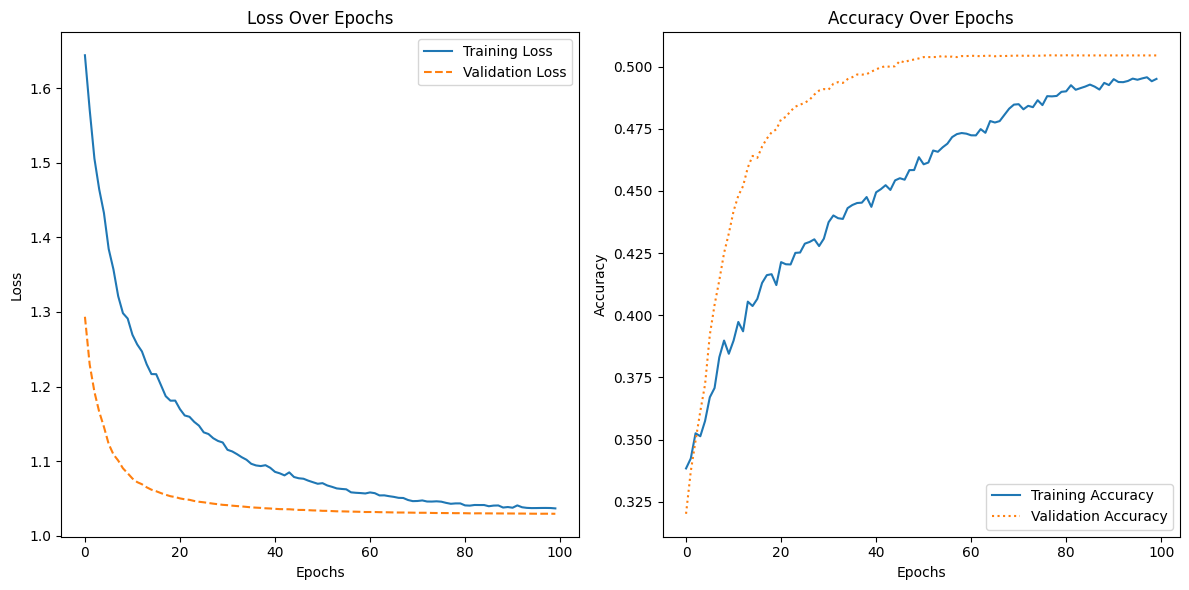

In [30]:
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle=':')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()